In [39]:
# General
import os
import re
import sklearn
import nltk
import numpy as np
import pandas as pd
import contractions
import glob
# Preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
# models
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet
from scipy.spatial.distance import pdist
# Plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn
import seaborn as sns
# Enable inline plotting  
%matplotlib inline

1) spell correction (https://github.com/cbaziotis/ekphrasis)<br>
2) Slang expansion<br>
3) coreferencing<br>

In [6]:
parent_dir = 'energy,renewable,plant'
subject_dirs = [os.path.join(parent_dir, dir) for dir in os.listdir(parent_dir) 
                if os.path.isdir(os.path.join(parent_dir, dir))]

In [7]:
subject_dirs

['energy,renewable,plant/IndiaTV',
 'energy,renewable,plant/RajyasabhaTV',
 'energy,renewable,plant/CNBCIndia',
 'energy,renewable,plant/NDTV',
 'energy,renewable,plant/Random']

In [8]:
filelist = []
for dir in subject_dirs:
    csv_files = [os.path.join(dir, csv) for csv in os.listdir(dir) if os.path.isfile(os.path.join(dir, csv)) and csv.endswith('.csv')]
    filelist.extend([file for file in csv_files])

In [9]:
df = []
for file in filelist:
    try:
        df.append(pd.read_csv(file,engine='python'))
    except Exception as e:
        print('error {} happened for file {}'.format(e,file))
    
data = pd.concat(df,axis=0)
data = shuffle(data)
data.index = range(len(data))

error No columns to parse from file happened for file energy,renewable,plant/CNBCIndia/cnbc5.csv
error Expected 21 fields in line 100, saw 321 happened for file energy,renewable,plant/Random/energy16.csv
error Expected 21 fields in line 289, saw 1541 happened for file energy,renewable,plant/Random/energy15.csv


In [10]:
len(data)

127637

In [11]:
data.columns

Index(['id', 'author', 'authorLink', 'authorThumb', 'text', 'likes', 'time',
       'timestamp', 'edited', 'hasReplies', 'repliesToken', 'numReplies',
       'reply.id', 'reply.author', 'reply.authorLink', 'reply.authorThumb',
       'reply.text', 'reply.likes', 'reply.time', 'reply.timestamp',
       'reply.edited'],
      dtype='object')

In [12]:
data.head()

,id,author,authorLink,authorThumb,text,likes,time,timestamp,edited,hasReplies,...,numReplies,reply.id,reply.author,reply.authorLink,reply.authorThumb,reply.text,reply.likes,reply.time,reply.timestamp,reply.edited
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Ugyp0RQs_ZonMVJeTF94AaABAg.8rZOLgHpLMk8r_5yy2qD1H,Daniel Yusuke Shimizu,/channel/UCrRXR6TCisn3-tlEhG7ITbQ,https://yt3.ggpht.com/a/AATXAJwA7AQbUJfdG6bR1j...,Wait I thought youtube is banned\n\n\n\nEdit: ...,16.0,1 year ago,1.553027e+12,True
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Ugycg4joZ62O9idnINp4AaABAg.8pLbzBGPegi8pp58hF7hEe,dickcheeze,/channel/UCdtkltGt2YqrrRuVuiGKWCg,https://yt3.ggpht.com/a/AATXAJxfKvRbVAe7BjOjfE...,Just beggar Indian,1.0,1 year ago,1.553011e+12,False
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,UgwVTU-ToiCbxbJOoy94AaABAg.8qSf3rQc16F8rjTzTmTTDq,victoria,/channel/UCbN8n1zAP2TPLXaO19PuqRA,https://yt3.ggpht.com/a/AATXAJwDNLQ4iH3N5bLDQC...,@Jckeitt3 yes we should all try and cut down o...,0.0,1 year ago,1.553011e+12,True
3,UgwsnmV5ReSXeFUlo3J4AaABAg,dagan_m,/channel/UCQ41nJ90IsChcXzvi6J3kAA,https://yt3.ggpht.com/a/AATXAJwifccYu3HIFYliD5...,Ganga cleaning is a mammoth project with almos...,0.0,1 year ago,1.553025e+12,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,UgzsEWQsRpJlOjfREFp4AaABAg,Jenica Casador Laguardia,/channel/UCHLm2J-Qxxhm7eMk8MAGBQw,https://yt3.ggpht.com/a/AATXAJx91L9Y546q66FGyG...,Why there's no action regarding with this issue?,0.0,1 year ago,1.553011e+12,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
data = data[~(data['text'].isnull() & data['reply.text'].isnull())]

In [14]:
len(data)

127637

In [15]:
data['text_merged'] = data['text'].astype(str)+data['reply.text'].astype(str)

## Preprocess

In [16]:
stopword = stopwords.words('english') 

In [17]:
def stemming(words):
    ps = nltk.stem.SnowballStemmer('english')
    new = []
    stem_words = [ps.stem(x) for x in words]
    return stem_words

In [18]:
def preprocess(sentence):
    sentence = contractions.fix(sentence)             # Replace contractions in string 
    sentence = re.sub('@\w+',"",str(sentence))        # remove mentions
    sentence = re.sub('#\w+',"",str(sentence))        # remove hashtags
    sentence = re.sub('http\S+',"",str(sentence))     # remove URLs
    sentence = re.sub('[^\w\s]'," ",str(sentence))    # remove punc
    sentence = re.sub('[^a-zA-Z]'," ",str(sentence))  # remove numbers
  
    sents = word_tokenize(sentence)                   # Tokenization
    sents = stemming(sents)
            
    new_sents = ""
    for i in range(len(sents)):                       # remove stopwords            
        if(sents[i].lower() not in stopword and sents[i]!='rt' and len(sents[i])>1):
            new_sents += sents[i].lower()+" "
    new_sents.strip()
    
    return new_sents

In [19]:
def preprocessing(xtrain):
    corpus = xtrain.apply(preprocess)
    return corpus

In [20]:
corpus = preprocessing(data['text_merged'])
corpus = corpus.drop_duplicates() 

## Feature Extraction

In [21]:
def featureextraction(corpus):
    
    vectorizer = TfidfVectorizer(max_df=.5,min_df=1,max_features=None,ngram_range=(1, 2),norm=None,binary=True,
                             use_idf=False,sublinear_tf=False,strip_accents = 'unicode',stop_words = 'english')
    vectorizer = vectorizer.fit(corpus)
    tfidf = vectorizer.transform(corpus)
    vocab = vectorizer.get_feature_names()

    return tfidf, vocab

In [22]:
tfidf, vocab = featureextraction(corpus)

In [23]:
np.shape(tfidf)

(114356, 688918)

## Agglomerative Hierarchical Clustering

__Pros__:
1) No assumption of a particular number of clusters (i.e. k-means)<br>
2) May correspond to meaningful taxonomies<br>
__Cons__:
1) Too slow for large data sets, O(𝑛2 log(𝑛))

The version of hierarchical clustering we will explore is called agglomerative clustering. Although Scikit-Learn has a library for this, it performs very slowly. Instead, we will choose to use another version of hierarchical clustering called fastcluster. This package is a C++ library with an interface in Python/SciPy.<br>
For more information, look here:<br>
http://danifold.net/fastcluster.html?section=1

User Manual:<br>
https://cran.r-project.org/web/packages/fastcluster/vignettes/fastcluster.pdf

In [24]:
from sklearn.decomposition import TruncatedSVD

In [25]:
svd = TruncatedSVD(n_components=10)

In [26]:
sv = svd.fit_transform(tfidf)

In [27]:
np.shape(sv)

(114356, 10)

In [28]:
# pca = PCA(n_components=50).fit_transform(tfidf.todense())

In [29]:
Z = fastcluster.linkage_vector(sv,method='ward', metric='euclidean')

In [30]:
Z_dataFrame = pd.DataFrame(data=Z, 
    columns=['clusterOne','clusterTwo','distance','newClusterSize']) 

In [31]:
Z

array([[3.27720000e+04, 3.49770000e+04, 0.00000000e+00, 2.00000000e+00],
       [8.19400000e+03, 5.35260000e+04, 0.00000000e+00, 2.00000000e+00],
       [1.63890000e+04, 8.45580000e+04, 0.00000000e+00, 2.00000000e+00],
       ...,
       [2.28706000e+05, 2.28707000e+05, 1.22306346e+02, 5.18890000e+04],
       [2.28683000e+05, 2.28708000e+05, 1.46837611e+02, 7.70420000e+04],
       [2.28680000e+05, 2.28709000e+05, 1.81878296e+02, 1.14356000e+05]])

### Dendrograms 

We can use a dendrogram to visualize the history of groupings and figure out the optimal number of clusters. <br>
1) Determine the largest vertical distance that doesn’t intersect any of the other clusters<br>
2) Draw a horizontal line at both extremities<br>
3) The optimal number of clusters is equal to the number of vertical lines going through the horizontal line

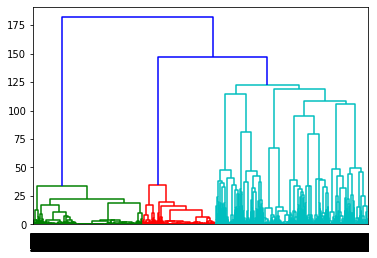

In [32]:
dend = dendrogram(Z)

Following the above procedures and the Dendogram above the optimum number of clusters is __three__.

In [33]:
from scipy.cluster.hierarchy import fcluster

distance_threshold = 130
clusters = fcluster(Z, distance_threshold, criterion='distance')

In [34]:
clusters

array([1, 3, 3, ..., 1, 3, 3], dtype=int32)

In [35]:
len(clusters)

114356

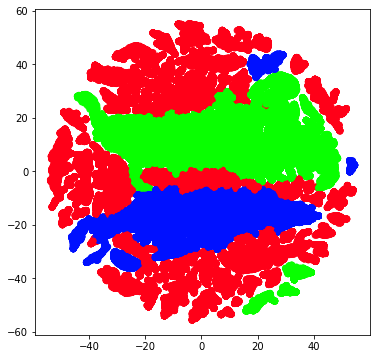

In [36]:
f, ax = plt.subplots(1, 1, figsize=(6, 6))
tsne = TSNE(n_components=2).fit_transform(sv)
max_label = max(clusters)
label_subset = [cm.hsv(i/max_label) for i in clusters]
ax.scatter(tsne[:, 0], tsne[:, 1], c=label_subset)

In [37]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

In [38]:
get_top_keywords(tfidf, clusters, vocab, 10)

DataError: No numeric types to aggregate